In [1]:
import json
import string
import random
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
with open('/content/Mental Health Conversational.json', 'r') as content:
  chatbot = json.load(content)
data = pd.DataFrame(chatbot['intents'])

In [4]:
dictionary = {"tag":[], "patterns":[], "responses":[]}
for i in range (len(data)):
  pattern = data[data.index==i]['patterns'].values[0]
  response = data[data.index==i]['responses'].values[0]
  tag = data[data.index==i]['tag'].values[0]
  for j in range (len(pattern)):
    dictionary['tag'].append(tag)
    dictionary['patterns'].append(pattern[j])
    dictionary['responses'].append(response)
data = pd.DataFrame.from_dict(dictionary)
data

,tag,patterns,responses
0,greeting,Hai,[Halo! Selamat bertemu denganmu. Bagaimana kab...
1,greeting,Halo,[Halo! Selamat bertemu denganmu. Bagaimana kab...
2,greeting,Hi,[Halo! Selamat bertemu denganmu. Bagaimana kab...
3,greeting,Hai apa kabar?,[Halo! Selamat bertemu denganmu. Bagaimana kab...
4,morning,Selamat pagi,[Selamat pagi. Saya harap Anda tidur nyenyak. ...
...,...,...,...
218,fact_28,Apa yang harus saya lakukan jika saya khawatir...,[Yang paling penting adalah berbicara dengan s...
219,fact_29,Bagaimana saya tahu kalau saya tidak sehat?,"[Jika keyakinan, pikiran, perasaan, atau peril..."
220,fact_30,Bagaimana saya bisa menjaga hubungan sosial? B...,"[Banyak orang yang sendirian saat ini, tapi ki..."
221,fact_31,Apa perbedaan antara kecemasan dan stres?,[Stres dan kecemasan sering digunakan secara b...


In [5]:
data['tag'].unique()

array(['greeting', 'morning', 'afternoon', 'evening', 'night', 'goodbye',
       'thanks', 'about', 'skill', 'creation', 'help', 'sad', 'stressed',
       'worthless', 'depressed', 'happy', 'casual', 'anxious',
       'not-talking', 'sleep', 'scared', 'death', 'understand', 'done',
       'suicide', 'hate-you', 'hate-me', 'default', 'jokes', 'repeat',
       'wrong', 'stupid', 'location', 'something-else', 'ask', 'problem',
       'no-approach', 'learn-more', 'user-agree', 'meditation',
       'user_meditation', 'hugu_useful', 'user-advice',
       'learn_mental_health', 'mental_health_fact', 'fact_1', 'fact_2',
       'fact_3', 'fact_4', 'fact_5', 'fact_6', 'fact_7', 'fact_8',
       'fact_9', 'fact_10', 'fact_11', 'fact_12', 'fact_13', 'fact_14',
       'fact_15', 'fact_16', 'fact_17', 'fact_18', 'fact_19', 'fact_20',
       'fact_21', 'fact_22', 'fact_23', 'fact_24', 'fact_25', 'fact_26',
       'fact_27', 'fact_28', 'fact_29', 'fact_30', 'fact_31', 'fact_32'],
      dtype=object)

In [6]:
with open('/content/word_dictionary.json', 'r') as f:
  json_dict = json.load(f)
tokenizer_json=json_dict.keys()

tokenizer = Tokenizer(lower=True, split=' ', oov_token='<OOV>')
combined = list(data['patterns']) + list(tokenizer_json)
tokenizer.fit_on_texts(combined)
word_index = tokenizer.word_index

tokenizer.get_config()
print(len(word_index))

88184


In [7]:
label_encode = LabelEncoder()
tokenizer.fit_on_texts(data['patterns'])

pattern_train = tokenizer.texts_to_sequences(data['patterns'])
x_train = pad_sequences(pattern_train, padding="post")
print("Input shape : ", x_train.shape)
print(len(x_train[0]))

Input shape :  (223, 18)
18


In [8]:
vocabulary = len(tokenizer.word_index)
print("Number unique word : ",vocabulary)

print()
x_label = label_encode.fit_transform(data['tag'])
print("Label shape : ", x_label.shape)
print("Output length : ", len(np.unique(x_label)))

Number unique word :  88184

Label shape :  (223,)
Output length :  77


In [9]:
# !rm -f glove.6B.zip
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-12-13 13:08:47--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-12-13 13:08:47--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.13MB/s    in 2m 39s  

2023-12-13 13:11:26 (5.18 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

In [10]:
glove_dir = "/content/glove.6B.100d.txt"
embeddings_index = {}
file_ = open(glove_dir, encoding='utf8')
for line in file_:
  arr = line.split()
  single_word = arr[0]
  w = np.asarray(arr[1:],dtype='float32')
  embeddings_index[single_word] = w
file_.close()
print(len(embeddings_index))

400000


In [11]:
max = vocabulary + 1
word_index =tokenizer.word_index
embedding_mat = np.zeros((max, 100)).astype(object)
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_mat[i] = embedding_vector

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_length=x_train.shape[1], input_dim=vocabulary+1, output_dim = 100, mask_zero=True,
                              weights=[embedding_mat], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(len(np.unique(x_label)), activation='softmax')
])

model.summary()
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 18, 100)           8818500   
                                                                 
 bidirectional_9 (Bidirecti  (None, 18, 128)           84480     
 onal)                                                           
                                                                 
 layer_normalization_12 (La  (None, 18, 128)           256       
 yerNormalization)                                               
                                                                 
 bidirectional_10 (Bidirect  (None, 18, 128)           98816     
 ional)                                                          
                                                                 
 layer_normalization_13 (La  (None, 18, 128)           256       
 yerNormalization)                                    

In [24]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('loss') < 0.3:
      self.model.stop_training = True

callback=MyCallback()
history = model.fit(x_train, x_label,
                    batch_size=10, epochs=500, callbacks=callback)
# [tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)]

Epoch 1/500
23/23 [==============================] - 27s 28ms/step - loss: 4.9134 - accuracy: 0.0493
Epoch 2/500
23/23 [==============================] - 1s 27ms/step - loss: 3.2220 - accuracy: 0.2377
Epoch 3/500
23/23 [==============================] - 1s 28ms/step - loss: 2.4593 - accuracy: 0.3991
Epoch 4/500
23/23 [==============================] - 1s 28ms/step - loss: 2.0575 - accuracy: 0.4888
Epoch 5/500
23/23 [==============================] - 1s 30ms/step - loss: 1.5366 - accuracy: 0.6323
Epoch 6/500
23/23 [==============================] - 1s 29ms/step - loss: 1.2280 - accuracy: 0.6726
Epoch 7/500
23/23 [==============================] - 1s 34ms/step - loss: 1.0627 - accuracy: 0.7085
Epoch 8/500
23/23 [==============================] - 1s 52ms/step - loss: 0.9832 - accuracy: 0.7265
Epoch 9/500
23/23 [==============================] - 1s 51ms/step - loss: 0.9253 - accuracy: 0.7399
Epoch 10/500
23/23 [==============================] - 1s 50ms/step - loss: 0.8644 - accuracy: 0.753

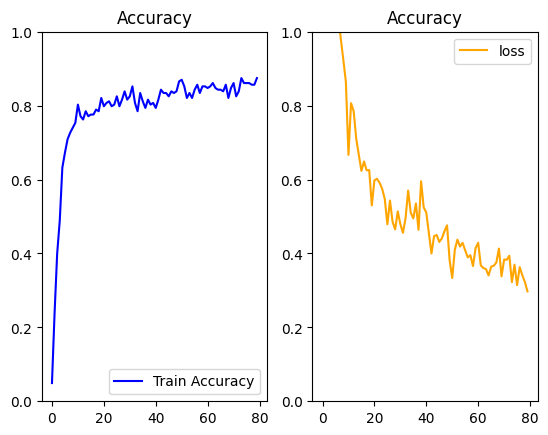

In [25]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color ='blue')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.ylim(0, 1.0)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss', color='orange')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.ylim(0, 1.0)
plt.show()

In [26]:
def chatbot_test():
  while True:
    user_input = input("User: ")

    pattern_test = tokenizer.texts_to_sequences([user_input])
    x_test = pad_sequences(pattern_test, padding="post")

    prediction = model.predict(x_test)[0]
    label = label_encode.inverse_transform([np.argmax(prediction)])[0]
    response = data[data['tag'] == label]['responses'].values[0]

    print("Chatbot: ", format(random.choice(response)))
    if label=='goodbye' or label=='thanks':
      break
chatbot_test()

User: hi
1/1 [==============================] - 7s 7s/step
Chatbot:  Halo! Senang bertemu denganmu. Apa yang bisa saya bantu?
User: pagi
1/1 [==============================] - 0s 40ms/step
Chatbot:  Selamat pagi. Saya harap Anda tidur nyenyak. Bagaimana perasaan Anda hari ini? 
User: siang
1/1 [==============================] - 0s 34ms/step
Chatbot:  Selamat siang. Bagaimana hari mu?
User: sore
1/1 [==============================] - 0s 23ms/step
Chatbot:  Selamat sore. Bagaimana hari mu?
User: malam
1/1 [==============================] - 0s 24ms/step
Chatbot:  Selamat malam. Tidur nyenyak 
User: saya sedang depresi
1/1 [==============================] - 8s 8s/step
Chatbot:  Menurutmu kenapa kamu merasa seperti ini?
User: istriku meninggal
1/1 [==============================] - 0s 34ms/step
Chatbot:  Saya sungguh sedih mendengarnya. Saya di sini untuk membantu Anda mengatasi kesedihan, kecemasan, dan hal lain yang mungkin Anda rasakan saat ini.
User: menurutmu apa itu depresi
1/1 [=====

KeyboardInterrupt: ignored

In [16]:
tf.saved_model.save(model,'/content/TFLite/')


In [17]:
saved_model_path = '/content/TFLite/'


loaded_model = tf.saved_model.load(saved_model_path)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

tflite_model_file = pathlib.Path('chatbot_model.tflite')
tflite_model_file.write_bytes(tflite_model)

39794768

In [18]:
from google.colab import files
files.download('chatbot_model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>